<a href="https://colab.research.google.com/github/rehan363/lang_chain/blob/main/5_agent_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet -U langchain_google_genai langchain_core langgraph


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.7 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
gemini_api_key = userdata.get('GOOGLE_API_KEY')

In [3]:
from google.colab import userdata
langchain_api_key = userdata.get('LANGCHAIN_API_KEY')

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

def multiply(a: int, b: int) -> int:
    """Multiply two integers
        Args:
            a: The first integer
            b: The second integer
        Returns:
            The product of the two integers"""
    return a * b

def add(a: int, b: int) -> int:
    """Add two integers
        Args:
            a: The first integer
            b: The second integer
        Returns:
            The sum of the two integers"""
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract two integers
        Args:
            a: The first integer
            b: The second integer
        Returns:
            The difference of the two integers"""
    return a - b

def  divide(a: int, b: int) -> int:
    """Divide two integers
        Args:
            a: The first integer
            b: The second integer
        Returns:
            The quotient of the two integers"""
    return a / b

tools= [divide, multiply, add, subtract]
llm= ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=gemini_api_key)
llm_with_tools= llm.bind_tools(tools)

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

#system message
sys_message= SystemMessage(content= "you are a helpfull assistant tasked with performing arithemtic on a set of inputs")

#node
def assistant(state: MessagesState) ->MessagesState:
  return{"messages": [llm_with_tools.invoke([sys_message] + state["messages"])]}

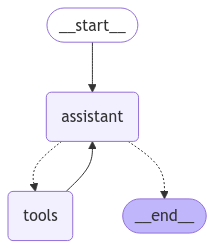

In [6]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import display, Image
from langgraph.graph.state import CompiledStateGraph

#graph
builder: StateGraph= StateGraph(MessagesState)

#defining nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

#defining edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    #if the latest message from the assistant (result) will be the tool call it will route towards tool node
    #if the latest message from the assistant (result) will not be the tool call it will route towards END node
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph: CompiledStateGraph = builder.compile()

#show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


checking memory

In [7]:
messages= [HumanMessage(content="multiply 4 by 6")]
messages= react_graph.invoke({"messages": messages})

for m in messages["messages"]:
    m.pretty_print()


================================ Human Message =================================

multiply 4 by 6
================================== Ai Message ==================================
Tool Calls:
  multiply (76c08c91-6888-4233-8d06-b6e363af8520)
 Call ID: 76c08c91-6888-4233-8d06-b6e363af8520
  Args:
    a: 4.0
    b: 6.0
================================= Tool Message =================================
Name: multiply

24
================================== Ai Message ==================================

The product of 4 and 6 is 24.


llm doesnot remember the previous calculation and previos  memory

In [8]:
messages= [HumanMessage(content="now multiply it by 7")]
messages= react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

now multiply it by 7
================================== Ai Message ==================================

What values would you like me to multiply by 7?  I need the inputs to perform the calculation.


We don't retain memory of 7 from our initial chat!

This is because state is transient to a single graph execution.

We can use persistence to address this!

LangGraph can use a ***checkpointer*** to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!




In [9]:
from langgraph.checkpoint.memory import MemorySaver

memory: MemorySaver = MemorySaver()
react_graph_memory: CompiledStateGraph = builder.compile(checkpointer=memory)

When we use memory, we need to specify a **thread_id**.

This **thread_id** will store our memory location of graph states collection.



**Transient State is temporary memory without any previous knowladge vs. Steady State is the memory with previous knowlagde**

In [13]:
#specify the thread
config1 ={"configurable": {"thread_id": "1"}}

#specify an input
messages= [HumanMessage(content="add 3 and 5")]

#run
messages = react_graph_memory.invoke({"messages": messages},config1)

for m in messages["messages"]:
    m.pretty_print()


#We called it 3 times

================================ Human Message =================================

add 3 and 5
================================== Ai Message ==================================
Tool Calls:
  add (c2508ec0-fdef-4759-8e85-44baa66f8975)
 Call ID: c2508ec0-fdef-4759-8e85-44baa66f8975
  Args:
    a: 3.0
    b: 5.0
================================= Tool Message =================================
Name: add

8
================================== Ai Message ==================================

The sum of 3 and 5 is 8.
================================ Human Message =================================

add 3 and 5
================================== Ai Message ==================================
Tool Calls:
  add (ab0f5dd3-eccc-40e8-bf45-a46d4b0bce8d)
 Call ID: ab0f5dd3-eccc-40e8-bf45-a46d4b0bce8d
  Args:
    a: 3.0
    b: 5.0
================================= Tool Message =================================
Name: add

8
================================== Ai Message ==================================

The s

remembers all the previous memory

In [14]:
messages= [HumanMessage(content= "multiply that with 2")]
messages= react_graph_memory.invoke({"messages": messages},config1)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

add 3 and 5
================================== Ai Message ==================================
Tool Calls:
  add (c2508ec0-fdef-4759-8e85-44baa66f8975)
 Call ID: c2508ec0-fdef-4759-8e85-44baa66f8975
  Args:
    a: 3.0
    b: 5.0
================================= Tool Message =================================
Name: add

8
================================== Ai Message ==================================

The sum of 3 and 5 is 8.
================================ Human Message =================================

add 3 and 5
================================== Ai Message ==================================
Tool Calls:
  add (ab0f5dd3-eccc-40e8-bf45-a46d4b0bce8d)
 Call ID: ab0f5dd3-eccc-40e8-bf45-a46d4b0bce8d
  Args:
    a: 3.0
    b: 5.0
================================= Tool Message =================================
Name: add

8
================================== Ai Message ==================================

The s